# Music recommender system
One of the most used machine learning algorithms is recommendation systems. A recommender (or recommendation) system (or engine) is a filtering system which aim is to predict a rating or preference a user would give to an item, eg. a film, a product, a song, etc.

collaborative-based filters predict what a user like based on what other users, that are similar to that particular user, have liked.

We have previously developed a content-based recommendation system. Now, we'll look into collaborative filtering.

## Collaborative filters
Collaborative Filters work with an interaction matrix, also called rating matrix. The aim of this algorithm is to learn a function that can predict if a user will benefit from an item - meaning the user will likely buy, listen to, watch this item.

Among collaborative-based systems, we can encounter two types: user-item filtering and item-item filtering.

What algorithms do collaborative filters use to recommend new songs? There are several machine learning algorithms that can be used in the case of collaborative filtering. Among them, we can mention nearest-neighbor, clustering, and matrix factorization.

**K-Nearest Neighbors (kNN)** is considered the standard method when it comes to both user-based and item-based collaborative filtering approaches.

We'll go through the steps for generating a music recommender system using a k-nearest algorithm approach.

# 1)  Importing required libraries
First, we'll import all the required libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# 2) Reading the files
We are going to use the **Million Song Dataset**, a freely-available collection of audio features and metadata for a million contemporary popular music tracks.

There are two files that will be interesting for us. The first of them will give us information about the songs. Particularly, it contains the user ID, song ID and the listen count. On the other hand, the second file will contain song ID, title of that song, release, artist name and year. We need to merge these two DataFrames. For that aim, we'll use the song_ID



In [3]:
#Read userid-songid-listen_count
song_info = pd.read_csv('10000.csv',header=None)
song_info.columns = ['user_id', 'song_id', 'listen_count']

#Reading Songs Data
song_actual =  pd.read_csv('song_data.csv')
song_actual.drop_duplicates(['song_id'], inplace=True)

#Merge the two dataframes above to create input dataframe for recommender systems
songs = pd.merge(song_info, song_actual, on="song_id", how="left")

In [4]:
songs.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


We'll save this dataset into a csv file so we have this available if there is any other recommendation system project we want to do.

In [6]:
songs.to_csv('songs1.csv', index=False)

We can read this file into a new DataFrame that we'd call df_songs.

In [7]:
df_songs = pd.read_csv('songs1.csv')

# 3) Exploring the data
As usual, any data science or machine learning project starts with an exploratory data analysis (EDA). The aim of EDA is to understand and get insights on our data.

We'll first inspect the first rows of our DataFrame.

In [8]:
df_songs.head()

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999


Then, we'll check how many observions there are in the dataset.

In [9]:
#Get total observations
print(f"There are {df_songs.shape[0]} observations in the dataset")

There are 1048576 observations in the dataset



Now, we should perform some cleaning steps. But looking at the dataset, we can see that there is no missing values.

In [10]:
df_songs.isnull().sum()

user_id         0
song_id         0
listen_count    0
title           0
release         0
artist_name     0
year            0
dtype: int64

In [11]:
df_songs.dtypes

user_id         object
song_id         object
listen_count     int64
title           object
release         object
artist_name     object
year             int64
dtype: object

And most of the columns contain strings.

Let's start exploring some characteristics of the dataset:

**Unique songs :**


In [12]:
#Unique songs
unique_songs = df_songs['title'].unique().shape[0]
print(f"There are {unique_songs} unique songs in the dataset")

There are 9567 unique songs in the dataset


**Unique Artists :**

In [14]:
#Unique artists
unique_artists = df_songs['artist_name'].unique().shape[0]
print(f"There are {unique_artists} unique artists in the dataset")

There are 3375 unique artists in the dataset


**Unique Users :**

In [13]:
#Unique users
unique_users = df_songs['user_id'].unique().shape[0]
print(f"There are {unique_users} unique users in the dataset")

There are 40336 unique users in the dataset


We'll go ahead and explore the popularity of songs and artists.

# 4) Most popular songs

How do we determine which are the most popular songs? For this task, we'll count how many times each song appears. Note that while we are using listen_count, we only care about the number of rows, we don't consider the number present in that row. This number represents how many times one user listen to the same song.



In [15]:
#count how many rows we have by song, we show only the ten more popular songs 
ten_pop_songs = df_songs.groupby('title')['listen_count'].count().reset_index().sort_values(['listen_count', 'title'], ascending = [0,1])
ten_pop_songs['percentage']  = round(ten_pop_songs['listen_count'].div(ten_pop_songs['listen_count'].sum())*100, 2)

In [16]:
ten_pop_songs = ten_pop_songs[:10]
ten_pop_songs

,title,listen_count,percentage
6836,Sehr kosmisch,4368,0.42
8725,Undo,3693,0.35
1964,Dog Days Are Over (Radio Edit),3676,0.35
9496,You're The One,3508,0.33
6498,Revelry,3179,0.30
6825,Secrets,3051,0.29
3437,Horn Concerto No. 4 in E flat K495: II. Romanc...,2830,0.27
2595,Fireflies,2514,0.24
3322,Hey_ Soul Sister,2469,0.24
8494,Tive Sim,2402,0.23


In [17]:
labels = ten_pop_songs['title'].tolist()
counts = ten_pop_songs['listen_count'].tolist()

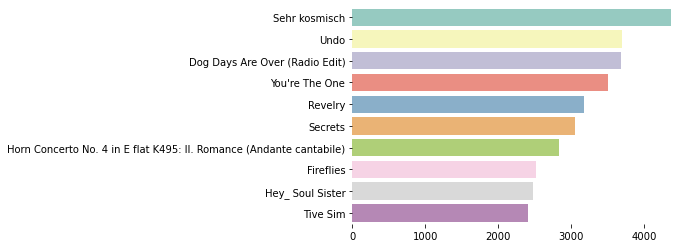

In [18]:
plt.figure()
sns.barplot(x=counts, y=labels, palette='Set3')
sns.despine(left=True, bottom=True)

# 5) Most popular artist
For the next task, we'll count how many times each artist appears. Again, we'll count how many times the same artist appears.

In [19]:
#count how many rows we have by artist name, we show only the ten more popular artist 
ten_pop_artists  = df_songs.groupby(['artist_name'])['listen_count'].count().reset_index().sort_values(['listen_count', 
                                                                                                        'artist_name'], 
                                                                                                ascending = [0,1])

In [20]:
ten_pop_artists = ten_pop_artists[:10]
ten_pop_artists

,artist_name,listen_count
649,Coldplay,15343
2850,The Black Keys,10589
1651,Kings Of Leon,9627
1107,Florence + The Machine,9524
1370,Jack Johnson,8726
2946,The Killers,8139
2374,Radiohead,8058
736,Daft Punk,7612
1554,Justin Bieber,7291
2073,Muse,7160


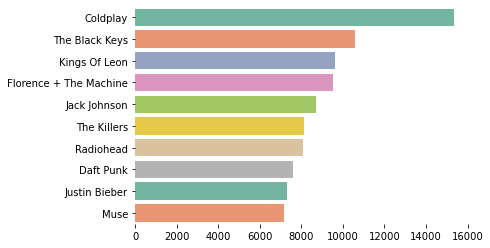

In [21]:
plt.figure()
labels = ten_pop_artists['artist_name'].tolist()
counts = ten_pop_artists['listen_count'].tolist()
sns.barplot(x=counts, y=labels, palette='Set2')
sns.despine(left=True, bottom=True)

# 6) Listen Count by User
We can also get some other information from the feature listen_count. We will answer the folloging question

**What was the maximum time the same user listen to a same song?**

In [22]:
listen_counts = pd.DataFrame(df_songs.groupby('listen_count').size(), columns=['count'])

In [23]:
print(f"The Max-time the same user listened the same song:{listen_counts.reset_index(drop=False)['listen_count'].iloc[-1]}")

The Max-time the same user listened the same song:920


**How many times on average the same user listen to a same song?**

In [24]:
print(f"On average, a user listen to the same song {df_songs['listen_count'].mean()} times")

On average, a user listen to the same song 3.0465383529663086 times


**What are the most frequent number of times a user listen to the same song?**

In [25]:
listen_counts_temp = listen_counts[listen_counts['count'] > 50].reset_index(drop=False)

In [26]:
print(listen_counts_temp)

    listen_count   count
0              1  595997
1              2  164538
2              3   75108
3              4   43485
4              5   48834
..           ...     ...
60            61      64
61            62      53
62            65      62
63            66      51
64            67      56

[65 rows x 2 columns]


**How many songs does a user listen in average?**

In [29]:
song_user = df_songs.groupby('user_id')['song_id'].count()

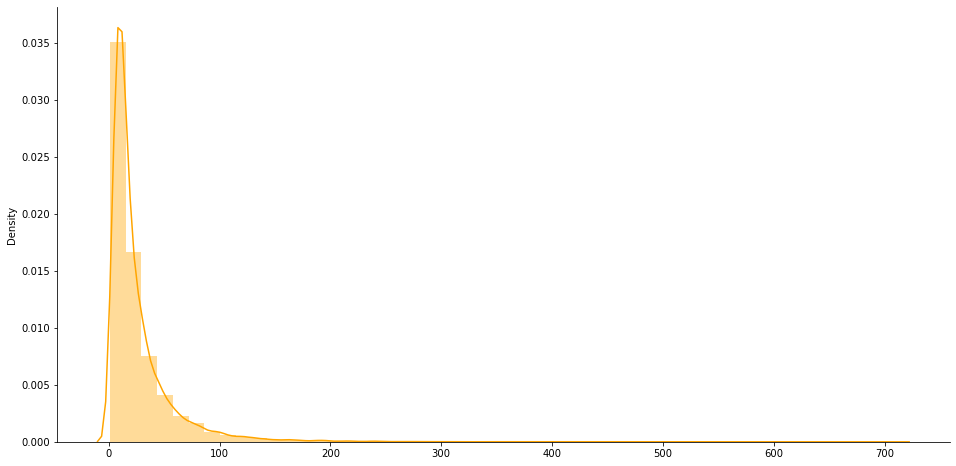

In [30]:
plt.figure(figsize=(16, 8))
sns.distplot(song_user.values, color='orange')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [31]:
print(f"A user listens to an average of {np.mean(song_user)} songs")

A user listens to an average of 25.996033320111067 songs


In [32]:
print(f"A user listens to an average of {np.median(song_user)} songs, and maximum {np.max(song_user)} songs")

A user listens to an average of 16.0 songs, and maximum 711 songs



We can see that a user listens in average to 27 songs. Even the maximum amount of songs listen by an user is 711, and we have 9567 songs in our dataset.

# 7) Prepare The Data

In [33]:
# Get users which have listen to at least 16 songs
song_ten_id = song_user[song_user > 16].index.to_list()

In [34]:
# Filtered the dataset to keep only those users with more than 16 listened
df_song_id_more_ten = df_songs[df_songs['user_id'].isin(song_ten_id)].reset_index(drop=True)

We need now to work with a scipy-sparse matrix to avoid overflow and wasted memory. For that purpose, we'll use the csr_matrix function from scipy.sparse.

# 8) Pivot table on User_id & Song_id

In [37]:
# convert the dataframe into a pivot table
df_pivot = df_song_id_more_ten.pivot(index='song_id', columns='user_id', values='listen_count').fillna(0)

df_pivot.head()

user_id,000ebc858861aca26bac9b49f650ed424cf882fc,000ef25cc955ad5841c915d269432eea41f4a1a5,0012bf75d43a724f62dc746d9e85ae0088a3a1d6,00185e316f07f0f00c325ca034be59c15b362401,001b005fe5e80d3cb45f320f5658fc8e2e72794e,001f22c638730aed5659034c447d3cf0e658898e,002543003041db1d049206b09426d5cdffc0f451,0028292aa536122c1f86fd48a39bd83fe582d27f,00292cf9c6d6e99c5ddbece7e37f957ab1362d25,00296f66ed7fb84c876486aecc9fab2d5809576d,...,ffcfb0b34a47fdf55b3d96c1799cd196677f8261,ffd6f34b343cee62cd7dbbf20fb1ab1119b299e5,ffdaab327f2fc6b9fa01a4e3e7f41fdd0e468046,ffdbaeb5cf2081eb34053a655c20f57524de11ba,ffebfec313fd515a11faba060b022f030b57fac0,fff22417a61c1ba3ee2592b22a052ed6a27a8e91,fff300cd094fe04030b79fae550dc9d065190182,fff543db7918cb8f4f56f7470903eb2f1d5a6dd8,fff6c30c773e6ffafcac213c9afd9666afaf6d63,fffce9c1537fbc350ea68823d956eaa8f5236dbe
song_id,,,,,,,,,,,,,,,,,,,,,
SOAAAGQ12A8C1420C8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAACPJ12A81C21360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAACSG12AB018DC80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAEJI12AB0188AB5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAFAC12A67ADF7EB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 9) Sparse Matrix (Compressed Sparse Row)

In [36]:
# obtain a sparse matrix
df_pivot_matrix = csr_matrix(df_songs_features.values)
print(df_pivot_matrix)

  (0, 1013)	1.0
  (0, 1917)	1.0
  (0, 2149)	5.0
  (0, 3882)	1.0
  (0, 4435)	12.0
  (0, 4719)	5.0
  (0, 5013)	1.0
  (0, 5187)	1.0
  (0, 5267)	20.0
  (0, 5395)	1.0
  (0, 8084)	6.0
  (0, 8811)	1.0
  (0, 10425)	1.0
  (0, 10635)	1.0
  (0, 11243)	1.0
  (0, 11462)	1.0
  (0, 11643)	1.0
  (0, 11925)	1.0
  (0, 12755)	1.0
  (0, 15127)	1.0
  (0, 15208)	2.0
  (0, 16053)	1.0
  (0, 18032)	1.0
  (0, 18317)	2.0
  (0, 18522)	5.0
  :	:
  (9999, 5588)	1.0
  (9999, 5826)	2.0
  (9999, 6196)	1.0
  (9999, 7071)	1.0
  (9999, 7195)	1.0
  (9999, 7416)	5.0
  (9999, 7501)	1.0
  (9999, 8673)	1.0
  (9999, 10303)	1.0
  (9999, 10633)	1.0
  (9999, 10752)	3.0
  (9999, 11284)	1.0
  (9999, 11745)	1.0
  (9999, 13484)	1.0
  (9999, 13782)	2.0
  (9999, 13862)	1.0
  (9999, 14495)	4.0
  (9999, 14806)	1.0
  (9999, 15606)	1.0
  (9999, 17160)	3.0
  (9999, 17181)	6.0
  (9999, 17317)	6.0
  (9999, 17735)	1.0
  (9999, 18730)	2.0
  (9999, 18893)	1.0


Because the system will output the id of the song, instead of the title, we'll make a function that maps those indices with the song title.

In [38]:
df_unique_songs = df_songs.drop_duplicates(subset=['song_id']).reset_index(drop=True)[['song_id', 'title']]

In [40]:
decode_id_song = {
    song: i for i, song in 
    enumerate(list(df_unique_songs.set_index('song_id').loc[df_pivot.index].title))
}

# 10) Matrix of Cosine Similarity

In [41]:
similarity_matrix = cosine_similarity(df_pivot)
similarity_matrix

array([[1.        , 0.01319032, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01319032, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

# 11) Fitting Data into NearestNeighborsModel

In [42]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', n_neighbors=20, radius=1)
model_knn.fit(df_pivot_matrix)

NearestNeighbors(metric='cosine', n_neighbors=20, radius=1)

# 12) Building Recommendation System 

In [47]:
def findRecomendations(model, matrix, query_index):
    distances, indices = model.kneighbors([matrix.iloc[query_index, :]], n_neighbors = 10)
    for i in range(0, len(distances.flatten())):
        if i == 0:
            rowDetails=df_songs.loc[df_songs['song_id'] == matrix.index[query_index]]
            print("Song: ", rowDetails.title.values[0], ", Artist: ",  rowDetails.artist_name.values[0] )
       
        else:
            rowDetails = df_songs.loc[df_songs['song_id'] == matrix.index[indices.flatten()[i]] ]
            print(" Recommendation", i, ": ")
            print("   Song: ", rowDetails.title.values[0])  
            print("   Artist: ",  rowDetails.artist_name.values[0])
            print("   Distance: ", distances.flatten()[i])

In [67]:
query_index = np.random.choice(df_pivot.shape[0])
query_index
query_index = 1000

In [68]:
distances, indices = model_knn.kneighbors([df_pivot.iloc[query_index, :]], n_neighbors = 10)
print(distances)
print(indices)

[[8.88178420e-16 2.54854806e-01 4.36555575e-01 4.53209934e-01
  4.57617398e-01 4.98731367e-01 5.46759531e-01 5.56802355e-01
  5.64142026e-01 5.64232031e-01]]
[[1000 4595 8408 8393  144 3710 8986 8331 6263   17]]


In [69]:
findRecomendations(model_knn, df_pivot, query_index)

Song:  Conspiracy (Album Version) , Artist:  Paramore
 Recommendation 1 : 
   Song:  Franklin (Album Version)
   Artist:  Paramore
   Distance:  0.2548548058758491
 Recommendation 2 : 
   Song:  All We Know (Album Version)
   Artist:  Paramore
   Distance:  0.43655557452452987
 Recommendation 3 : 
   Song:  Whoa (Album Version)
   Artist:  Paramore
   Distance:  0.45320993447098434
 Recommendation 4 : 
   Song:  When It Rains (Album Version)
   Artist:  Paramore
   Distance:  0.4576173981035182
 Recommendation 5 : 
   Song:  Emergency (Album Version)
   Artist:  Paramore
   Distance:  0.4987313667064892
 Recommendation 6 : 
   Song:  My Heart (Album Version)
   Artist:  Paramore
   Distance:  0.5467595309957625
 Recommendation 7 : 
   Song:  Let The Flames Begin (Album Version)
   Artist:  Paramore
   Distance:  0.5568023551083382
 Recommendation 8 : 
   Song:  Here We Go Again (Album Version)
   Artist:  Paramore
   Distance:  0.5641420259054202
 Recommendation 9 : 
   Song:  Halleluj